In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from celluloid import Camera
from torch_geometric.data import Data
import torch
import sys
import os
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)
from simulations.n_body_trajectory import n_body_simulation
from gnn_model.graph_structure_from_trajecotry import node_data_list
from gnn_model.message_passing_MLP import GNN_MLP
from gnn_model.train_model import train_model

In [2]:
def convert_to_plot_format(trajectory_data):
    """
    Convert simulation output to format expected by plot_simulation().
    Returns: data list and times array.
    """
    positions = trajectory_data["positions"]          # shape: (T, N, dim)
    masses = trajectory_data["masses"]                # shape: (N,)
    times = trajectory_data["time"].numpy()           # shape: (T,)

    # Expand masses over time so it's (T, N, 1)
    masses_expanded = masses[None, :, None].expand(positions.shape[0], -1, 1)

    # Concatenate along last dimension to get (T, N, dim + 1)
    data_run = torch.cat([positions, masses_expanded], dim=-1).numpy()

    # Wrap in a list to support multiple runs
    return [data_run], times

In [ ]:
# def make_transparent_color(length, offset=0.0):
#     """Simple RGBA gradient from opaque to transparent"""
#     return [(0, 0, 1, alpha) for alpha in np.linspace(1, 0, length)]  # Blue, adjustable if you want

def make_transparent_color(ntimes, fraction):
  rgba = np.ones((ntimes, 4))
  alpha = np.linspace(0, 1, ntimes)[:, np.newaxis]
  color = np.array(mpl.colors.to_rgba(mpl.cm.gist_ncar(fraction)))[np.newaxis, :]
  rgba[:, :] = 1*(1-alpha) + color*alpha
  rgba[:, 3] = alpha[:, 0]
  return rgba

def plot_simulation(data, times, sim_type='r2', i=0, animate=False, plot_size=True, s_size=1):
    """
    Plots simulation data.
    
    :data: list of simulation runs, each of shape (nt, n, d+1) -- the last dimension includes mass
    :times: array of shape (nt,)
    :sim_type: 'r2', 'string', etc.
    :i: index of the run to plot
    :animate: whether to animate
    """
    x_times = np.array(data[i])  # shape (nt, n, d+1)
    n = x_times.shape[1]
    masses = x_times[:, :, -1]

    if not animate:
        if sim_type in ['string', 'string_ball']:
            rgba = make_transparent_color(len(times), 0)
            for i in range(0, len(times), len(times)//10):
                ctimes = x_times[i]
                plt.plot(ctimes[:, 0], ctimes[:, 1], color=rgba[i])
            plt.xlim(-5, 20)
            plt.ylim(-20, 5)
        else:
            for j in range(n):
                rgba = make_transparent_color(len(times), j/n)
                if plot_size:
                    plt.scatter(x_times[:, j, 0], x_times[:, j, 1], color=rgba, s=3*masses[:, j]*s_size)
                else:
                    plt.scatter(x_times[:, j, 0], x_times[:, j, 1], color=rgba, s=s_size)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Simulation {i}")
        plt.show()
    else:
        if sim_type in ['string', 'string_ball']:
            raise NotImplementedError("Animation for string types not supported.")
        fig = plt.figure()
        camera = Camera(fig)
        d_idx = 20
        for t_idx in range(d_idx, len(times), d_idx):
            start = max([0, t_idx-300])
            cx_times = x_times[start:t_idx]
            for j in range(n):
                rgba = make_transparent_color(len(cx_times), j/n)
                if plot_size:
                    plt.scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba, s=3*masses[start:t_idx, j]*s_size)
                else:
                    plt.scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba, s=s_size)

                        # Set axis limits here
            # plt.xlim(-5, 10)
            # plt.ylim(-5, 10)
            camera.snap()
        from IPython.display import HTML
        return HTML(camera.animate().to_jshtml())


In [4]:
# def odefunc(y, t=None):
#     """
#     y: flattened state vector [x1, y1, vx1, vy1, mass1, ..., xN, yN, vxN, vyN, massN]
#     t: current time (can be None; PyTorch GNN doesn't use it)
#     """
#     y = y.reshape(N, 5)  # assuming [x, y, vx, vy, mass]
    
#     # Extract position and velocity
#     pos = y[:, 0:2]
#     vel = y[:, 2:4]
#     mass = y[:, 4:5]

#     # Construct input feature matrix
#     # Optional: broadcast time as an extra feature
#     time_col = torch.full((N, 1), float(t) if t is not None else 0.0)
#     x = torch.from_numpy(torch.cat([pos, vel, mass, time_col], dim=1)).float().to(device)

#     # Package edge_index and x into a Data object
#     data = Data(x=x, edge_index=edge_index)

#     # Predict acceleration
#     acc = model(data.x, data.edge_index)  # shape: (N, 2)

#     dx = vel.numpy()
#     dv = acc.cpu().detach().numpy()
#     dmass = np.zeros_like(mass.numpy())

#     dydt = np.concatenate([dx, dv, dmass], axis=1).ravel()
#     return dydt


In [5]:
# def build_initial_state(trajectory_data):
#     """
#     Returns the initial state vector for odeint, shaped (N * 5,)
#     Format per node: [x, y, vx, vy, mass]
#     """
#     positions = trajectory_data["positions"]      # (T, N, 2)
#     velocities = trajectory_data["velocities"]    # (T, N, 2)
#     masses = trajectory_data["masses"]            # (N,)
    
#     N = positions.shape[1]
    
#     init_state = torch.cat([
#         positions[0],         # (N, 2)
#         velocities[0],        # (N, 2)
#         masses[:, None]       # (N, 1)
#     ], dim=1).flatten().numpy()  # Shape: (N * 5,)
    
#     return init_state

In [6]:
# def make_odefunc(model, edge_index, device='cpu'):
#     def odefunc(y, t=None):
#         N = edge_index.max().item() + 1
#         y = y.reshape(N, 5)  # [x, y, vx, vy, mass]
        
#         pos = y[:, 0:2]
#         vel = y[:, 2:4]
#         mass = y[:, 4:5]
#         time_col = np.full((N, 1), float(t) if t is not None else 0.0)

#         # Build input feature tensor
#         x = torch.from_numpy(np.concatenate([pos, vel, mass, time_col], axis=1)).float().to(device)
#         data = Data(x=x, edge_index=edge_index.to(device))
        
#         acc = model(data.x, data.edge_index)  # acceleration prediction (N, 2)
        
#         dx = vel
#         dv = acc.cpu().detach().numpy()
#         dmass = np.zeros_like(mass)
        
#         dydt = np.concatenate([dx, dv, dmass], axis=1).ravel()
#         return dydt
#     return odefunc


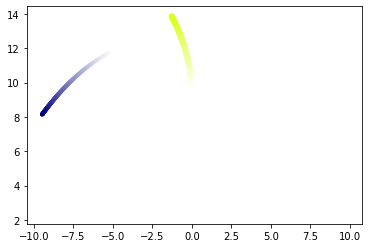

In [42]:
trajectory_data = n_body_simulation(2, 1000, 0.02, box_size=10, min_dist=2.5, velocity_scale=1)
data, times = convert_to_plot_format(trajectory_data)
plot_simulation(data, times, sim_type='r2', animate=True) 

In [ ]:
trajectory_data = n_body_simulation(3, 1000, 0.02, box_size=10, min_dist=2.5, velocity_scale=1)
data, times = convert_to_plot_format(trajectory_data)
plot_simulation(data, times, sim_type='r2', animate=True) 


In [ ]:
# import pickle
# # Save to a file
# with open("trajectory_data_nice.pkl", "wb") as f:
#     pickle.dump(trajectory_data, f)

In [9]:
positions = trajectory_data["positions"]      # (T, N, 2)
velocities = trajectory_data["velocities"]    # (T, N, 2)
masses = trajectory_data["masses"]

init_state = torch.cat([
    positions[0],     # (N, 2)
    velocities[0],    # (N, 2)
    masses[:, None]   # (N, 1)
], dim=1).flatten().numpy()  # Shape: (N * 5,)

In [ ]:
def animate_truth_vs_prediction(trajectory_data, model, edge_index, device='cpu',
                                 length_of_tail=50, d_idx=5, cutoff_time=300,
                                 save_path='truth_vs_pred.mp4', fps=20):
    positions = trajectory_data["positions"]  # (T, N, 2)
    masses = trajectory_data["masses"]
    times = trajectory_data["time"].numpy()[:cutoff_time]
    N = positions.shape[1]

    # Build initial state
    init_state = torch.cat([
        positions[0],         # (N, 2)
        trajectory_data["velocities"][0],  # (N, 2)
        masses[:, None]       # (N, 1)
    ], dim=1).flatten().numpy()  # Shape: (N * 5,)

    # Define ODE function
    def odefunc(y, t=None):
        y = y.reshape(N, 5)
        pos = y[:, 0:2]
        vel = y[:, 2:4]
        mass = y[:, 4:5]
        time_col = np.full((N, 1), float(t) if t is not None else 0.0)
        x = torch.from_numpy(np.concatenate([pos, vel, mass, time_col], axis=1)).float().to(device)
        data = Data(x=x, edge_index=edge_index.to(device))
        acc = model(data.x, data.edge_index)
        dx = vel
        dv = acc.cpu().detach().numpy()
        dmass = np.zeros_like(mass)
        dydt = np.concatenate([dx, dv, dmass], axis=1).ravel()
        return dydt

    # Run prediction
    from scipy.integrate import odeint
    pred = odeint(odefunc, init_state, times)
    x_times2 = pred.reshape(-1, N, 5)  # [T, N, 5]
    x_times1 = positions[:cutoff_time]

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    camera = Camera(fig)

    for t_idx in range(d_idx, len(times), d_idx):
        start = max([0, t_idx - length_of_tail])
        ctimes1 = x_times1[start:t_idx]
        ctimes2 = x_times2[start:t_idx]

        for j in range(N):
            rgba = make_transparent_color(len(ctimes1), j/N)
            ax[0].scatter(ctimes1[:, j, 0], ctimes1[:, j, 1], color=rgba)
            ax[1].scatter(ctimes2[:, j, 0], ctimes2[:, j, 1], color=rgba)

            black_rgba = rgba.copy()
            black_rgba[:, :3] = 0.0  # dark trail
            ax[1].scatter(ctimes1[:, j, 0], ctimes1[:, j, 1], color=black_rgba, zorder=-1)

        for k in range(2):
            ax[k].set_xlim(-5, 5)
            ax[k].set_ylim(-5, 5)
            ax[k].set_title("Truth" if k == 0 else "Prediction")
        plt.tight_layout()
        camera.snap()

    animation = camera.animate()
    animation.save(save_path, fps=fps)
    print(f"Animation saved to '{save_path}'")


In [7]:
# loading data
graph_data_trajectory = node_data_list(trajectory_data, self_loop=False, complete_graph=True)

# initialising model
model = GNN_MLP(n_f=6, m_dim=2, out_channels=2, hidden_channels=128)
train_model(model, graph_data_trajectory, lr=0.01, epochs=100)

/Users/ruxi/Documents/GitHub/DeepLearningPH/gnn_model/graph_structure_from_trajecotry.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target = torch.tensor(acceleration, dtype=torch.float32)


GNN_MLP()

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

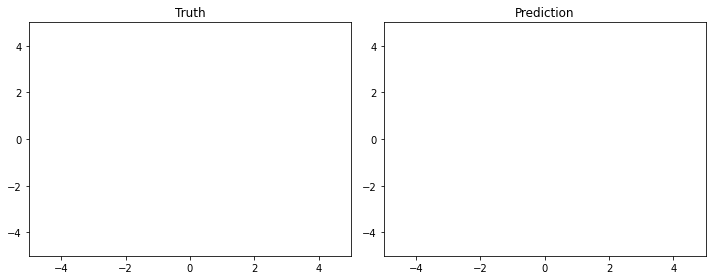

In [11]:
model.eval()
animate_truth_vs_prediction(trajectory_data, model, edge_index = graph_data_trajectory[0].edge_index)